In [1]:
%load_ext autoreload
%autoreload 2

Completed Sudoku Puzzles: https://www.kaggle.com/datasets/bryanpark/sudoku

In [2]:
import numpy as np

solutions_9by9 = np.zeros((10000, 81), np.int32)
for i, line in enumerate(open('sudoku.csv', 'r').read().splitlines()[1:]):
    if i >= solutions_9by9.shape[0]:
        break

    quiz, solution = line.split(",")
    for j, q_s in enumerate(zip(quiz, solution)):
        q, s = q_s
        solutions_9by9[i, j] = s

solutions_9by9 = solutions_9by9.reshape((-1, 9, 9))

In [3]:
solutions_6by6 = solutions_9by9[:,:6,:6]

In [4]:
SIZE = 9

In [5]:
if SIZE == 9:
    solutions = solutions_9by9
elif SIZE == 6:
    solutions = solutions_6by6

In [6]:
num_train = 10000

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.nn import Flatten
import torch

import random

transform = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)),
                          Flatten(0)
                          ])
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
testset = datasets.MNIST('data', download=True, train=False, transform=transform)

train_ids = random.sample(range(0, 50000), num_train)

In [8]:
class SudokuDataset(Dataset):
    def __init__(self, dataset, digit_ids, solutions):
        self.dataset = dataset
        
        self.digit_to_id = {}

        for d in range(10):
            self.digit_to_id[d] = []

        for d_id in digit_ids:
            self.digit_to_id[dataset[d_id][1]].append(d_id)
    
        print('num digit_ids: ', len(digit_ids))
        print('solutions: ', len(solutions))
        
        
        self.solution_image_ids = torch.empty((solutions.shape[0],
                                               solutions.shape[1] ** 2), dtype=torch.int32) # n x 36 or 81
        for i, sol in enumerate(solutions):
            for j, digit in enumerate(sol.flatten()):
                self.solution_image_ids[i, j] = self.get_id_from_digit(digit)

    def get_id_from_digit(self, digit):
        return random.sample(self.digit_to_id[digit], 1)[0]
    
    def __len__(self):
        return self.solution_image_ids.shape[0]
    
    def __getitem__(self, idx):
        digit_ids = self.solution_image_ids[idx]
        
        images = torch.empty((self.solution_image_ids.shape[1], 28 * 28))
        labels = torch.empty((self.solution_image_ids.shape[1],))
        
        for i, d_id in enumerate(digit_ids):
            images[i] = self.dataset[d_id][0]
            labels[i] = self.dataset[d_id][1]
        
        images = torch.unsqueeze(images, dim=0)
        labels = torch.unsqueeze(labels, dim=0)
        
        return {'images': images, 'labels': labels}
    
s_data = SudokuDataset(trainset, train_ids, solutions[:1000])


num digit_ids:  10000
solutions:  1000


In [9]:
from matplotlib import pyplot as plt

def viz(images):
    plt.figure(figsize=(10, 10))
    
    fig, axes = plt.subplots(SIZE, SIZE)
    
    for ax, img in zip(axes.flatten(), images[0]):
        ax.imshow(img.reshape(28, 28))
        ax.set_yticklabels([])
        ax.set_xticklabels([])

In [10]:
s_data[0]['labels'].shape

torch.Size([1, 81])

<Figure size 720x720 with 0 Axes>

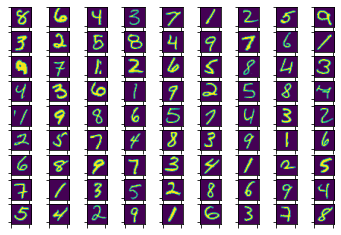

In [11]:
viz(s_data[0]['images'])

In [89]:
import sys
sys.path.append('../../')

import logging
logging.basicConfig(level=logging.INFO)

from regr.graph import Graph, Concept, Relation
from regr.graph.logicalConstrain import andL, existsL, notL, atMostL, ifL, fixedL, eqL, exactL
from regr.graph import EnumConcept
from regr.sensor.pytorch.sensors import JointSensor, ReaderSensor, FunctionalSensor
from regr.sensor.pytorch.learners import ModuleLearner

In [90]:
Graph.clear()
Concept.clear()
Relation.clear()

with Graph('global') as graph:
    sudoku = Concept("sodoku")
    
    empty_entry = Concept(name='empty_entry')
    (empty_rel, ) = sudoku.contains(empty_entry)
    
    same_row = Concept(name="same_row")
    (same_row_arg1, same_row_arg2) = same_row.has_a(row1=empty_entry, row2=empty_entry)
    
    same_col = Concept(name="same_col")
    (same_col_arg1, same_col_arg2) = same_col.has_a(col1=empty_entry, col2=empty_entry)
    
    same_table = Concept(name="same_table")
    (same_table_arg1, same_table_arg2) = same_table.has_a(table1=empty_entry, table2=empty_entry)
    
    empty_entry_label = empty_entry(name="empty_entry_label", ConceptClass=EnumConcept, 
                                    values=[f'v{d}' for d in range(SIZE)])
    v = [getattr(empty_entry_label, a) for a in ('', *empty_entry_label.enum)]

    for row_num in range(6):
        for j in range(1, 7):
            exactL(v[j](path = (eqL(empty_entry, "rows", {row_num}))))
            exactL(v[j](path = (eqL(empty_entry, "cols", {row_num}))))
            exactL(v[j](path = (eqL(empty_entry, "tables", {row_num}))))

/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('row1', 'empty_entry'), ('row2', 'empty_entry')]) is used.
  if sys.path[0] == '':
/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('col1', 'empty_entry'), ('col2', 'empty_entry')]) is used.
  from ipykernel import kernelapp as app
/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('table1', 'empty_entry'), ('table2', 'empty_entry')]) is used.


In [91]:
cols_indices = torch.arange(SIZE).repeat((SIZE, 1)).flatten()
rows_indices = torch.arange(SIZE).repeat((SIZE, 1)).T.flatten()
cols_indices = cols_indices.unsqueeze(-1) # 81 x 1
rows_indices = rows_indices.unsqueeze(-1) # 81 x 1

In [92]:
tables_indices = torch.empty((SIZE, SIZE))

for i in range(0, SIZE, 3):
    for j in range(0, SIZE, 3):
        tables_indices[i:i+3, j:j+3] = i + j//3

tables_indices = tables_indices.flatten().unsqueeze(-1) # 81 x 1

In [93]:
from cnn import Net

In [94]:
sudoku['images'] = ReaderSensor(keyword='images') # 1 x 81 x 784
sudoku['all_logits'] = ModuleLearner('images', module=Net(SIZE)) # 1 x 81 x 9

sudoku['labels'] = ReaderSensor(keyword='labels') # 1 x 81

In [95]:
def unpack(logits, labels):
    return torch.ones((SIZE ** 2, 1)), rows_indices, cols_indices, tables_indices, logits[0], labels.reshape(SIZE ** 2, 1)


In [96]:
empty_entry[empty_rel, 'rows', 'cols', 'tables', 'logits', 'label'] = JointSensor(sudoku['all_logits'],
                                                                         sudoku['labels'],
                                                                         forward=unpack)

In [97]:
empty_entry[empty_entry_label] = FunctionalSensor('logits', forward=lambda x: x)

In [98]:
# sanity check
#empty_entry[empty_entry_label] = FunctionalSensor('label', forward=lambda x: torch.unsqueeze(x, dim=0), label=True)

In [99]:
from regr.program import SolverPOIProgram
from regr.program.metric import MacroAverageTracker
from regr.program.loss import NBCrossEntropyLoss

'''program = SolverPOIProgram(
        graph,
        poi=(sudoku, empty_entry, same_row, same_col, same_table),
        inferTypes=['local/argmax'],
        loss=MacroAverageTracker(NBCrossEntropyLoss()),
)'''

"program = SolverPOIProgram(\n        graph,\n        poi=(sudoku, empty_entry, same_row, same_col, same_table),\n        inferTypes=['local/argmax'],\n        loss=MacroAverageTracker(NBCrossEntropyLoss()),\n)"

In [100]:
from regr.program.lossprogram import SampleLossProgram, PrimalDualProgram
from regr.program.model.pytorch import SolverModel

'''class CallbackProgram(SampleLossProgram):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.after_train_epoch = []

    def call_epoch(self, name, dataset, epoch_fn, **kwargs):
        if name == 'Testing':
            for fn in self.after_train_epoch:
                fn(kwargs)
        else:
            super().call_epoch(name, dataset, epoch_fn, **kwargs)


program = CallbackProgram(graph, SolverModel,
                    poi=(sudoku, empty_entry, same_row, same_col, same_table),
                    inferTypes=['local/argmax'],
                    sample=True,
                    sampleSize=2000,
                    sampleGlobalLoss=True,
                    beta=1)'''


"class CallbackProgram(SampleLossProgram):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.after_train_epoch = []\n\n    def call_epoch(self, name, dataset, epoch_fn, **kwargs):\n        if name == 'Testing':\n            for fn in self.after_train_epoch:\n                fn(kwargs)\n        else:\n            super().call_epoch(name, dataset, epoch_fn, **kwargs)\n\n\nprogram = CallbackProgram(graph, SolverModel,\n                    poi=(sudoku, empty_entry, same_row, same_col, same_table),\n                    inferTypes=['local/argmax'],\n                    sample=True,\n                    sampleSize=2000,\n                    sampleGlobalLoss=True,\n                    beta=1)"

In [101]:
class CallbackProgram(PrimalDualProgram):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.after_train_epoch = []

    def call_epoch(self, name, dataset, epoch_fn, **kwargs):
        if name == 'Testing':
            for fn in self.after_train_epoch:
                fn(kwargs)
        else:
            super().call_epoch(name, dataset, epoch_fn, **kwargs)


program = CallbackProgram(graph, SolverModel,
                    poi=(sudoku, empty_entry, same_row, same_col, same_table),
                    inferTypes=['local/argmax'])

In [102]:
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

def get_classification_report(dataloader, sample_num=10):
    preds_all = []
    labels_all = []

    for d_idx, node in tqdm(enumerate(program.populate(dataloader)), total=len(dataloader)):
        node.inferLocal()

        preds = torch.empty((SIZE ** 2))
        labels = node.getAttribute('labels')

        for i, entry in enumerate(node.getChildDataNodes(conceptName=empty_entry)):
            entry_pred = torch.argmax(entry.getAttribute('<empty_entry_label>/local/argmax'), dim=0)

            preds[i] = entry_pred
        
        if d_idx < sample_num:
            print(preds.reshape(SIZE, SIZE))

            print(labels.reshape(SIZE, SIZE))
            
            print('\n\n')

        preds_all.extend(preds.tolist())
        labels_all.extend(labels.tolist()[0])

    print(classification_report(labels_all, preds_all))

def post_epoch_metrics(kwargs):
    get_classification_report(trainloader)

In [103]:
program.after_train_epoch = [post_epoch_metrics]

In [104]:
trainloader = DataLoader(
    s_data,
    shuffle=False
)

In [105]:
optim = lambda param: torch.optim.Adam(param, lr=0.05)

In [106]:
program.train(trainloader,
              train_epoch_num=10,
              Optim=optim,
              device='auto',
              test_every_epoch=True,
              c_warmup_iters=0
             )

INFO:regr.program.program:Epoch: 1
INFO:regr.program.program:Training:
Epoch 1 Training:   0%|          | 1/1000 [00:00<06:56,  2.40it/s]


RuntimeError: output with shape [] doesn't match the broadcast shape [1]